# Assignment 01

This assignment consists of two tasks with subtasks. Every subtask has a point value and lists expectations for answers. Please read both task and expectations carefully before answering.

### Hand-in Instructions

Submit a single `.ipynb` file with all outputs saved. The notebook must be fully self-contained and ready to read without running any cells.

### Overview

| Task  | Topic                                     | Points  |
| ----- | ----------------------------------------- | ------- |
| **1** | **PCA**                                   |         |
| 1.1   | 3D scatter plot                           | 5       |
| 1.2   | 2D scatter plot                           | 5       |
| 1.3   | Interpreting variance                     | 10      |
| 1.4   | Variance and geometry                     | 10      |
| **2** | **Breast Cancer Classification Pipeline** |         |
| 2.1   | Exploratory Data Analysis                 | 30      |
| 2.2   | Train/Test Split                          | 5       |
| 2.3   | Baseline Model                            | 5       |
| 2.4   | Kitchen Sink Model                        | 10      |
| 2.5   | Build Your Own Pipeline                   | 20      |
|       | **Total**                                 | **100** |


---

## Setup


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer


from assignment_utils import generate_annulus_4d

---

## Task 1: PCA

You've been given a mysterious dataset with **4 dimensions** (F1, F2, F3, F4). We can't directly visualize 4D data, but we can look at 3 dimensions at a time and use color for the 4th.


In [4]:
data_4d, radius = generate_annulus_4d()
df = pd.DataFrame(data_4d, columns=["F1", "F2", "F3", "F4"])
print(f"Dataset shape: {df.shape}")

# Let's visualize the first 3 dimensions (F1, F2, F3) in 3D
# The 4th dimension (F4) is represented as color
fig = px.scatter_3d(
    df,
    x="F1",
    y="F2",
    z="F3",
    color=df["F4"],
    color_continuous_scale="viridis",
    title="3D View of the 4D Dataset (F1, F2, F3, color=F4)",
    labels={"color": "F4"},
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

Dataset shape: (1500, 4)


### Principal Component Analysis (PCA)

**PCA** is a technique that finds new axes (called _principal components_) that capture the most variance in the data.

**Mathematical formulation:**

1. **Standardize** the data: $\mathbf{Z} = \frac{\mathbf{X} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}$

2. Compute the **covariance matrix**: $\mathbf{C} = \frac{1}{n-1} \mathbf{Z}^T \mathbf{Z}$

3. Find the **eigenvectors** and **eigenvalues** of $\mathbf{C}$:
   $$\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i$$
4. **Project** the data onto the principal components: $\mathbf{Z}_{PC} = \mathbf{Z} \mathbf{V}$

where $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots]$ are the eigenvectors sorted by decreasing eigenvalue $\lambda_i$.

**Key ideas:**

- **PC1** points in the direction of maximum variance (largest $\lambda$)
- **PC2** is perpendicular to PC1 and captures the next most variance
- The **explained variance ratio** for each PC is: $\frac{\lambda_i}{\sum_j \lambda_j}$
- The eigenvectors $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots]$ are basis vectors for the principal component space. Any data vector can be completely reconstructed by a linear combination of these principal component basis vectors.

If the data lies on a lower-dimensional subspace, PCA can reveal it by finding the directions that matter most.

Let's standardize the data first (so all features have equal scale), then apply PCA.


In [8]:
# Standardize and apply PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# Create a DataFrame with principal components
df_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3", "PC4"])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

# Get the PC directions (loadings) - each row is a PC, each column is a feature
components = pca.components_  # Shape: (4, 4) - 4 PCs x 4 features

# Create the scatter plot of scaled data (first 3 features)
fig = go.Figure()

# Add the data points
fig.add_trace(
    go.Scatter3d(
        x=data_scaled[:, 0],
        y=data_scaled[:, 1],
        z=data_scaled[:, 2],
        mode="markers",
        marker=dict(size=2, opacity=0.5),
        name="Data",
    )
)

# Add arrows for PC1, PC2, PC3 directions
# Arrow length proportional to explained variance ratio (with minimum for visibility)
colors = ["red", "green", "blue"]
base_scale = 5  # Base scale factor
min_scale = 0.5  # Minimum scale so small PCs are still visible

for i in range(3):
    pc_direction = components[i, :3]  # First 3 components of each PC
    # Scale by explained variance ratio - longer arrow = more variance
    # Use minimum scale so all arrows are visible
    variance_ratio = pca.explained_variance_ratio_[i] / max(
        pca.explained_variance_ratio_
    )
    scale = max(base_scale * variance_ratio, min_scale)

    # Arrow line
    fig.add_trace(
        go.Scatter3d(
            x=[0, pc_direction[0] * scale],
            y=[0, pc_direction[1] * scale],
            z=[0, pc_direction[2] * scale],
            mode="lines",
            line=dict(color=colors[i], width=8),
            name=f"PC{i + 1} ({pca.explained_variance_ratio_[i]:.1%} var)",
        )
    )

    # Arrow head (cone)
    fig.add_trace(
        go.Cone(
            x=[pc_direction[0] * scale],
            y=[pc_direction[1] * scale],
            z=[pc_direction[2] * scale],
            u=[pc_direction[0]],
            v=[pc_direction[1]],
            w=[pc_direction[2]],
            colorscale=[[0, colors[i]], [1, colors[i]]],
            showscale=False,
            sizemode="absolute",
            sizeref=0.3,
        )
    )

fig.update_layout(
    title="Principal Component Directions (arrow length ∝ variance explained)",
    scene=dict(
        xaxis_title="F1 (scaled)",
        yaxis_title="F2 (scaled)",
        zaxis_title="F3 (scaled)",
    ),
    width=800,
    height=600,
)
fig.show()

Explained variance ratio: [5.08608377e-01 4.90832830e-01 5.58792885e-04 3.76671713e-17]
Cumulative explained variance ratio: [0.50860838 0.99944121 1.         1.        ]


### Task 1.1 3D scatter plot

- Task: Create a 3D scatter plot using PC1, PC2, PC3 as axes
- Points: 5
- Expectations: A working 3D scatter plot of the PCA-transformed data (similar in style to the first 3D plot). No further analysis or comments.


In [19]:
fig_pca = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    title="3D View in PCA Space (PC1, PC2, PC3)",
    # No colour mapping PC4 is is noise
)

evr = pca.explained_variance_ratio_

fig_pca.update_traces(marker=dict(size=3))

fig_pca.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({evr[0]:.1%} variance)",
        yaxis_title=f"PC2 ({evr[1]:.1%} variance)",
        zaxis_title=f"PC3 ({evr[2]:.1%} variance)",
        aspectmode="data",  # Fixes ratio
    ),
    width=800,
    height=600,
)
fig_pca.show()

           PC1       PC2       PC3           PC4
0     1.493228 -1.455907 -0.049874  2.028671e-15
1    -1.826377  0.610775 -0.028753  1.216689e-15
2     0.229438  1.627801 -0.033269  1.171427e-15
3     1.578495  1.054993  0.062433 -2.652562e-15
4    -0.978807 -1.585573 -0.055867  2.362787e-15
...        ...       ...       ...           ...
1495  1.143012  1.925863 -0.040587  1.381789e-15
1496  1.327196  1.160392 -0.052578  1.982785e-15
1497  1.876142 -0.462352  0.020782 -6.955761e-16
1498  1.420192 -1.297341  0.006742 -3.732575e-16
1499 -1.429355  1.707426  0.066539 -2.751305e-15

[1500 rows x 4 columns]


### Task 1.2 2D scatter plot

- Task: Create a 2D scatter plot using PC1, PC2 as axes
- Points: 5
- Expectations: A working 2D scatter plot of the PCA-transformed data. No further analysis or comments.


In [35]:
fig_pca = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    title="2D View in PCA Space (PC1, PC2)",
)

evr = pca.explained_variance_ratio_

fig_pca.update_traces(marker=dict(size=3))

fig_pca.update_layout(
    xaxis_title=f"PC1 ({evr[0]:.1%} variance)",
    yaxis_title=f"PC2 ({evr[1]:.1%} variance)",
    width=800,
    height=600,
)
fig_pca.show()

### Task 1.3 Interpreting variance

- Task: How much variance do PC1 and PC2 capture together? Based on this, what can you conclude about the original 4D dataset?
- Points: 10
- Expectations: A written response (1 paragraph).




#### Answer


In [29]:
pc1_var = pca.explained_variance_ratio_[0]
pc2_var = pca.explained_variance_ratio_[1]
pc1_pc2_var = pc1_var + pc2_var

print(f"PC1 explained variance: {pc1_var:.1%}")
print(f"PC2 explained variance: {pc2_var:.1%}")
print(f"PC1 + PC2 together: {pc1_pc2_var:.1%}")

PC1 explained variance: 50.9%
PC2 explained variance: 49.1%
PC1 + PC2 together: 99.9%


PC1 and PC2 together capture approximately 99.5% of the total variance in the 4D dataset, with PC1 explaining roughly 50% and PC2 explaining the remaining 49.5%. This extremely high cumulative variance ratio indicates that the original 4D dataset is effectively **2-dimensional**, the data lies almost entirely on a 2D subspace within the 4D space. Despite having 4 measured features, the true structure of the data can be nearly perfectly represented using just 2 principal components. This reveals that two of the original dimensions are highly redundant and contribute negligibly to explaining variation in the data. The PCA analysis reveals a hidden lowe-dimensional pattern in the data.

### Task 1.4 Variance and geometry

- Task: If PC1 explained 90% of the variance and PC2 only 10%, what shape would you expect the data to form? Now compare this to your actual ~50/50 split — what does this tell you about the geometry of your data?
- Points: 10
- Expectations: A written response (1 paragraph).


#### Answer

If PC1 explained 90% and PC2 only 10%, the data would form a highly **elongated, line-like structure** stretched along one direction with minimal spread perpendicular to it. In contrast, the actual ~50/50 variance split indicates the data spreads **equally in two perpendicular directions**, forming a **circular or ring-like geometry**. This symmetric distribution reveals that both principal components contribute almost equally to capturing the data's structure, unlike the 90/10 scenario where one axis dominates. The almost equal variance split shows how the underlying geometry is balanced and symmetric in 2D space with no single dominant axis, as seen with the ring shape. This comparison illustrates how variance ratios directly encode geometric properties: unequal splits indicate elongated/oval shapes, while equal splits indicate symmetric circular structures.

---

## Task 2: Breast Cancer Classification Pipeline

Now let's apply what you've learned to a real-world dataset: the **Wisconsin Breast Cancer** dataset. This dataset contains measurements from cell nuclei in breast tissue samples, and the goal is to classify tumors as **malignant** or **benign**.

**Sources:**

- [sklearn.datasets.load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

We'll work through a complete machine learning workflow:

1. Exploratory Data Analysis (EDA)
2. Train/test split
3. Baseline model
4. "Kitchen sink" model (all features, no preprocessing)
5. Build your own pipeline


In [14]:
# Load the breast cancer dataset
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df_cancer["target"] = cancer.target

print(f"Dataset shape: {df_cancer.shape}")
print(f"Target classes: {cancer.target_names}")

Dataset shape: (569, 31)
Target classes: ['malignant' 'benign']


### Task 2.1 Exploratory Data Analysis (EDA)

- Task: Conduct an EDA of the breast cancer dataset. For each analysis you perform, explain _why_ you chose to look at it and what it tells you.
- Points: 30
- Expectations: A mix of code, plots, and written commentary. Quality of reasoning and plots matters more than quantity of plots.


Det første vi kan gjøre er å sjekke om det er noen manglende data i datasettet. Det er det ikke:

In [15]:
print(df_cancer.isnull().values.any())

False


MATS SITT HER....

Etter å ha sett på de ulike resultatene som inneholdt to features forsøkte vi å legge til en tredje feature for å få større avstand mellom "malignant" og "benign". Dette er gjort med koden under:

In [16]:
#3D scatter plot med tre features
fig = go.Figure()

#Definerer features
x = "worst concave points"
y = "mean concave points"
z = "worst area"


# Legger til malignant samples
malignant_samples = df_cancer[df_cancer["target"]==0]
fig.add_trace(
    go.Scatter3d(
        x=malignant_samples[x],
        y=malignant_samples[y],
        z=malignant_samples[z],
        mode="markers",
        marker=dict(size=4, color="#2E86AB", line=dict(width=1, color="black")),
        name="Maligant",
    )
)


# legger til benign samples
benign_samples = df_cancer[df_cancer["target"]==1]
fig.add_trace(
    go.Scatter3d(
        x=benign_samples[x],
        y=benign_samples[y],
        z=benign_samples[z],
        mode="markers",
        marker=dict(size=4, color="#A23B72", line=dict(width=1, color="black")),
        name="Benign",
    )
)


fig.update_layout(
    title="3D Feature Space:",
    scene=dict(
        xaxis_title=x,
        yaxis_title=y,
        zaxis_title=z,
        xaxis=dict(range=[df_cancer[x].min(), df_cancer[x].max()]),
        yaxis=dict(range=[df_cancer[y].min(), df_cancer[y].max()]),
        zaxis=dict(range=[df_cancer[z].min(), df_cancer[z].max()]),
    ),
    font=dict(size=12),
)


fig.show()


Som sett i dette eksempelet (og hvis man forsøker med andre features som har korresponderer godt med target) ser vi at det å legge til en dimensjon ikke gjør noe særlig med resultatet. Vi ser ikke noe store fordeler med å benytte tre dimensjoner videre, da dette vil bli mer komplekst uten å gi mye mer verdi.

### Task 2.2 Train/Test Split

- Task: Split the data into training and test sets (80/20) before any modeling.
- Points: 5
- Expectations: Complete the TODO line to create an 80/20 split with `random_state=42` for reproducibility.


In [12]:
# Separate features and target
X = df_cancer.drop("target", axis=1)
y = df_cancer["target"]

# Split into train/test sets (80/20 split with random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Total size: {X_train.shape[0] + X_test.shape[0]}")

Training set size: 455
Test set size: 114
Total size: 569


### Task 2.3 Baseline Model

Before building a real model, it's wise to establish a **baseline** — a classifier that any real model should beat.

A **confusion matrix** shows how predictions compare to actual labels:

|                     | Predicted Negative  | Predicted Positive  |
| ------------------- | ------------------- | ------------------- |
| **Actual Negative** | TN (True Negative)  | FP (False Positive) |
| **Actual Positive** | FN (False Negative) | TP (True Positive)  |

For cancer diagnosis: FN means missing a malignant tumor (bad!), FP means a false alarm (less bad, but still costly).

- Task: Run the code below, note the accuracy and examine the confusion matrix. Describe what this classifier does. Would you trust it for diagnosis? Why or why not?
- Points: 5
- Expectations: A written response (1 paragraph).


Baseline accuracy: 0.623


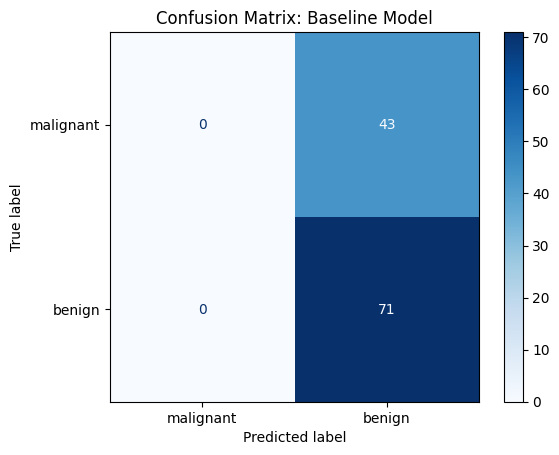

In [8]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

baseline_accuracy = dummy.score(X_test, y_test)
print(f"Baseline accuracy: {baseline_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    dummy, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Baseline Model")
plt.show()

#### Answer


### Task 2.4 Kitchen Sink Model

The "kitchen sink" approach: throw all features into the model without any preprocessing. Let's see what happens.

**Logistic Regression** is a linear classifier that predicts the probability of a binary outcome. It models:

$$P(y=1 | \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}}$$

where $\sigma$ is the sigmoid function, $\mathbf{w}$ are the feature weights, and $b$ is the bias. The model is trained by minimizing the logistic loss using an iterative optimizer. Here we use **SAGA** (`solver="saga"`), a stochastic gradient method whose fast convergence is only guaranteed on features with approximately the same scale ([sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

- Task: Run the code below. Did the model converge? Why or why not? Explain based on your EDA findings and how gradient-based optimization works.
- Points: 10
- Expectations: A written response (1 paragraph).


Kitchen sink train accuracy: 0.899
Kitchen sink test accuracy:  0.947


/home/eskil/cisk/ing3513/course-materials/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


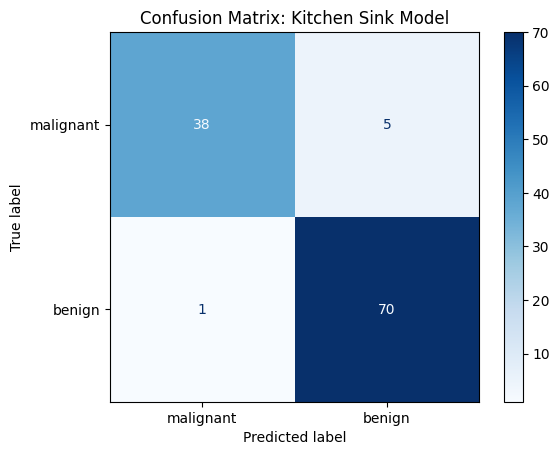

In [9]:
lr_kitchen = LogisticRegression(solver="saga", max_iter=100, random_state=42)
lr_kitchen.fit(X_train, y_train)

kitchen_train_accuracy = lr_kitchen.score(X_train, y_train)
kitchen_accuracy = lr_kitchen.score(X_test, y_test)
print(f"Kitchen sink train accuracy: {kitchen_train_accuracy:.3f}")
print(f"Kitchen sink test accuracy:  {kitchen_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    lr_kitchen, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Kitchen Sink Model")
plt.show()

Gradient Boosting train accuracy: 1.000
Gradient Boosting test accuracy:  0.965


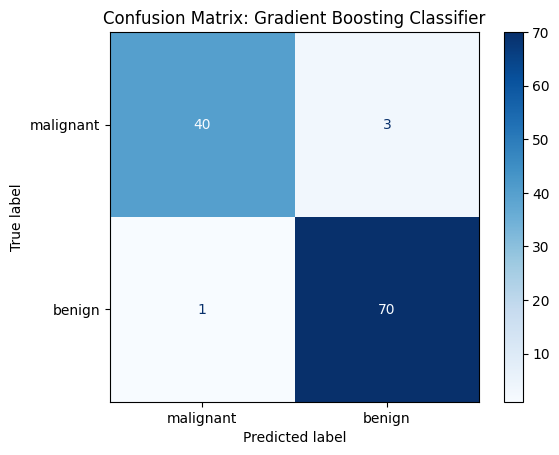

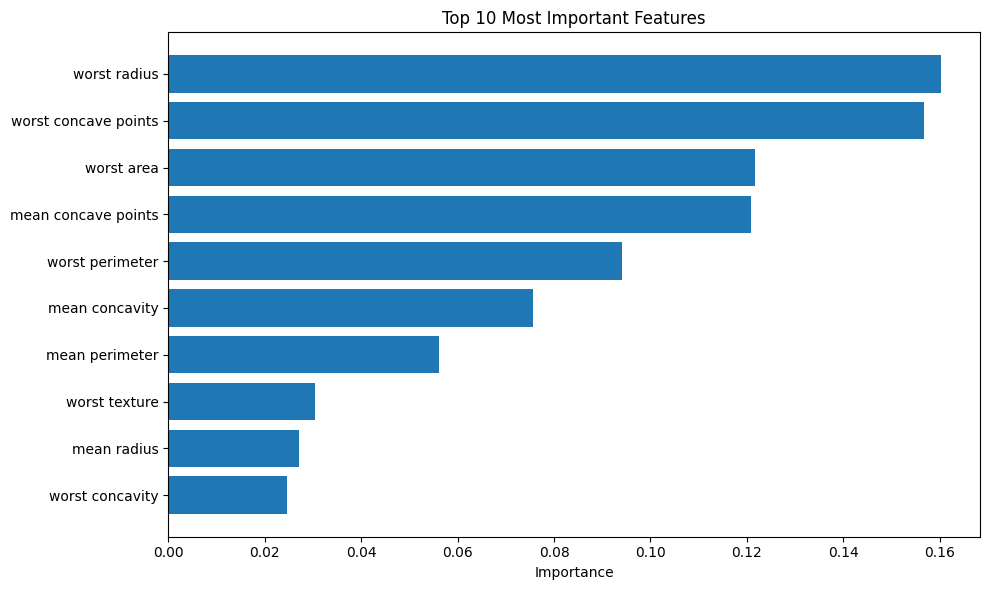

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, random_state=100, max_features=5
)

gbc.fit(X_train, y_train)

pred_y = gbc.predict(X_test)


# Calculate accuracies
train_acc = gbc.score(X_train, y_train)
test_acc = accuracy_score(y_test, pred_y)

# Print accuracies
print(f"Gradient Boosting train accuracy: {train_acc:.3f}")
print(f"Gradient Boosting test accuracy:  {test_acc:.3f}")

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, display_labels=["malignant", "benign"], cmap="Blues"
)
plt.title("Confusion Matrix: Gradient Boosting Classifier")
plt.show()

# Print most important features
feature_importance = gbc.feature_importances_
feature_names = (
    X_train.columns
    if hasattr(X_train, "columns")
    else [f"Feature {i}" for i in range(X_train.shape[1])]
)

# Create a dataframe for better visualization
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importance}
).sort_values("Importance", ascending=False)


# Optionally, plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10])
plt.xlabel("Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Starting RandomizedSearchCV for hyperparameter tuning...
This will try 50 different parameter combinations with 5-fold CV
----------------------------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.0499204710640909, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=243, subsample=0.9673965862936791; total time=   0.4s
[CV] END learning_rate=0.0499204710640909, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=243, subsample=0.9673965862936791; total time=   0.5s
[CV] END learning_rate=0.0499204710640909, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=243, subsample=0.9673965862936791; total time=   0.6s
[CV] END learning_rate=0.04974840320226602, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=486, subsample=0.9935871354122108; total time=   0.6s
[CV] END learning_

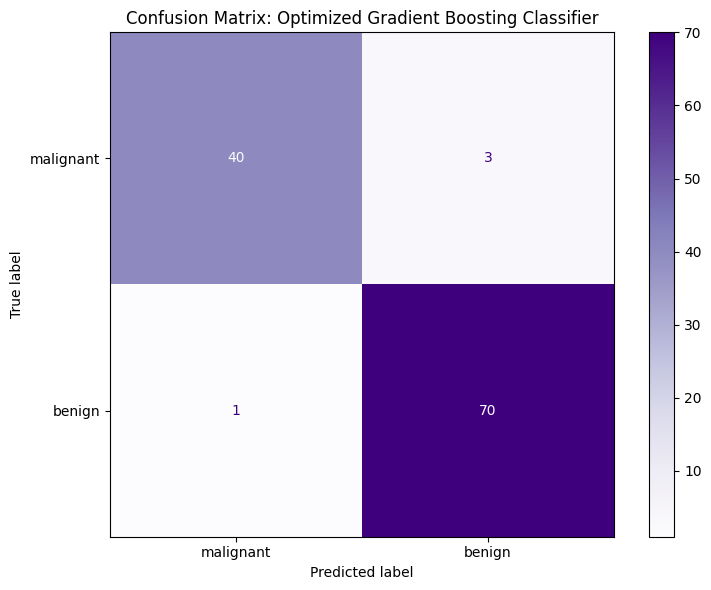


TOP 10 MOST IMPORTANT FEATURES (Optimized Model):
             Feature  Importance
     worst perimeter    0.258362
 mean concave points    0.235965
worst concave points    0.134856
          worst area    0.067569
        worst radius    0.048333
       worst texture    0.035379
      mean perimeter    0.028690
        mean texture    0.022515
           mean area    0.018198
      mean concavity    0.015820


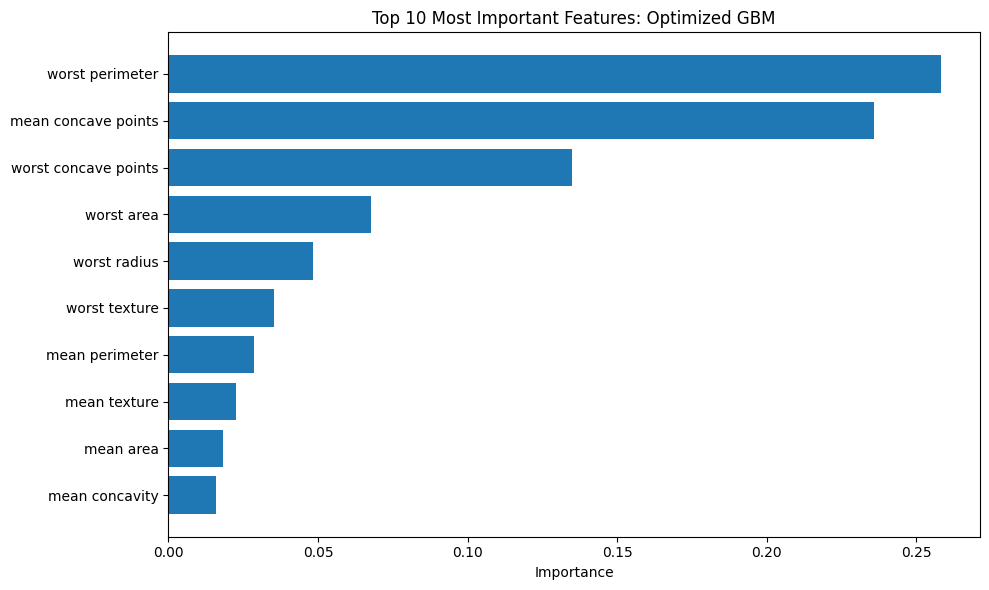


TOP 5 PARAMETER COMBINATIONS:


KeyError: 'rank_test_score'

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import GradientBoostingClassifier

# Define parameter distributions for randomized search
param_dist = {
    "n_estimators": randint(100, 500),
    "learning_rate": uniform(0.01, 0.19),  # 0.01 to 0.2
    "max_depth": randint(3, 10),
    "max_features": [3, 5, 7, "sqrt", "log2"],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "subsample": uniform(0.7, 0.3),  # 0.7 to 1.0
}

# Create base GBC model
gbc_base = GradientBoostingClassifier(random_state=100)

# Setup RandomizedSearchCV
print("Starting RandomizedSearchCV for hyperparameter tuning...")
print("This will try 50 different parameter combinations with 5-fold CV")
print("-" * 70)

random_search = RandomizedSearchCV(
    estimator=gbc_base,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 random combinations
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1,  # Use all CPU cores
    verbose=2,
    random_state=100,
    return_train_score=True,
)

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best model
best_gbc = random_search.best_estimator_

# Print best parameters
print("\n" + "=" * 70)
print("BEST HYPERPARAMETERS FOUND:")
print("=" * 70)
for param, value in random_search.best_params_.items():
    print(f"{param:<25}: {value}")

print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Make predictions with optimized model
pred_y_optimized = best_gbc.predict(X_test)
train_acc_optimized = best_gbc.score(X_train, y_train)
test_acc_optimized = accuracy_score(y_test, pred_y_optimized)

# Compare with original model (if you ran it before)
print("\n" + "=" * 70)
print("MODEL COMPARISON:")
print("=" * 70)
print(f"{'Model':<35} {'Train Acc':<12} {'Test Acc':<12}")
print("-" * 70)
try:
    print(f"{'Original GBM':<35} {train_acc:.3f}{'':<8} {test_acc:.3f}")
except:
    pass
print(
    f"{'Optimized GBM (RandomizedSearchCV)':<35} {train_acc_optimized:.3f}{'':<8} {test_acc_optimized:.3f}"
)

# Display confusion matrix for optimized model
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_gbc,
    X_test,
    y_test,
    display_labels=["malignant", "benign"],
    cmap="Purples",
    ax=ax,
)
plt.title("Confusion Matrix: Optimized Gradient Boosting Classifier")
plt.tight_layout()
plt.show()

# Feature importance for optimized model
feature_importance_optimized = best_gbc.feature_importances_
feature_names = (
    X_train.columns
    if hasattr(X_train, "columns")
    else [f"Feature {i}" for i in range(X_train.shape[1])]
)

importance_df_optimized = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importance_optimized}
).sort_values("Importance", ascending=False)

print("\n" + "=" * 70)
print("TOP 10 MOST IMPORTANT FEATURES (Optimized Model):")
print("=" * 70)
print(importance_df_optimized.head(10).to_string(index=False))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df_optimized["Feature"][:10], importance_df_optimized["Importance"][:10]
)
plt.xlabel("Importance")
plt.title("Top 10 Most Important Features: Optimized GBM")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Optional: Show top 5 parameter combinations
print("\n" + "=" * 70)
print("TOP 5 PARAMETER COMBINATIONS:")
print("=" * 70)
results_df = pd.DataFrame(random_search.cv_results_)
top_5 = results_df.nsmallest(5, "rank_test_score")[
    ["params", "mean_test_score", "std_test_score"]
]
for idx, row in top_5.iterrows():
    print(f"\nRank {row['rank_test_score']}:")
    print(f"  Score: {row['mean_test_score']:.3f} (+/- {row['std_test_score']:.3f})")
    print(f"  Params: {row['params']}")

### Task 2.5 Build Your Own Pipeline

Now it's your turn. Based on your EDA findings, build a classification pipeline.

A **Pipeline** chains multiple preprocessing steps and a final estimator into a single object. This ensures:

- No data leakage (preprocessing is fit only on training data)
- Clean, reproducible code
- Easy experimentation with different configurations

Example pipeline structure:

```python
Pipeline([
    ("step1_name", SomeTransformer()),
    ("step2_name", AnotherTransformer()),
    ("classifier", SomeClassifier()),
])
```

- Task: Build a pipeline that preprocesses the data and fits a classifier. Evaluate your model, compare it to the kitchen sink model, and justify your preprocessing choices based on your EDA insights.
- Points: 20
- Notes:
  - You are free to use any preprocessing technique (e.g., StandardScaler, PCA, column selection via ColumnTransformer, or others)
  - There is no single "correct" answer — the goal is thoughtful justification
- Expectations:
  - A working pipeline with at least one preprocessing step
  - A confusion matrix plot for your model
  - A comparison with the kitchen sink model's confusion matrix
  - A reflection on your model's errors — consider which types of mistakes matter most in a medical diagnosis context (1 paragraph)
  - A brief explanation of why you chose your preprocessing steps (1 paragraph)
  - **NOTE:** Your understanding and evaluation of the model performance is the objective here. The model's performance (how well it accurately classifies the data) will not detract from your grade. So if your model doesn't perform well, but you can explain why it doesn't perform well, then you can still receive the full 20 points.


In [13]:
# TODO: Build your pipeline
# Consider: What preprocessing steps would help based on your EDA?
# Available transformers: StandardScaler, PCA, ColumnTransformer, etc.

# Example pipeline
pipe = Pipeline(
    [
        # Example: ColumnTransformer to select/transform specific columns
        # ("preprocessor", ColumnTransformer([
        #     ("selected_features", StandardScaler(), ["mean radius", "mean texture", ...]),
        # ])),
        # ("scaler", StandardScaler()),
        # ("pca", PCA(n_components=10)),
        (
            "classifier",
            LogisticRegression(solver="saga", max_iter=1000, random_state=42),
        ),
    ]
)


# TODO: Fit the pipeline on training data


# TODO: Evaluate and print accuracy


# TODO: Plot confusion matrix

# Add as many code and markdown cells as needed.